# Applying Vector Embeddings to GUFI Snapshots

## Objective

The goal of this notebook is to analyze and compare **GUFI snapshots** of Linux kernel indexes (in this case) using vector embeddings. By extracting key metadata features and applying embedding techniques, we aim to uncover temporal and structural relationships between snapshots. These insights can help quantify differences in filesystem characteristics across Linux kernel versions.

### Why Vector Embeddings?

GUFI snapshots contain extensive metadata, such as file sizes, access times, permissions, and more. To analyze this metadata efficiently:
- We treat each snapshot as a **high-dimensional vector**, where each dimension represents a feature.
- **Vector embeddings** reduce these high-dimensional representations into lower-dimensional space, making them easier to compare and visualize.

### Key Steps:
1. Load and process snapshot data from GUFI indexes.
2. Extract and normalize key metadata features.
3. Apply dimensionality reduction techniques to create embeddings.
4. Compare embeddings using distance/similarity metrics (e.g., Euclidean distance, Cosine similarity).
5. Visualize results using heatmaps to highlight relationships between snapshots.

### Importance:
- Helps identify temporal trends or changes in Linux kernel indexes.
- Quantifies similarities and differences between snapshots, providing actionable insights into filesystem evolution.
- Demonstrates a scalable approach to analyzing large-scale metadata for future applications.

---




### Imports

In [484]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
#import umap.umap_ as umap
#from sklearn.cluster import KMeans

### 1. Load and process GUFI snapshots

We have **GUFI snapshots** of various Linux kernels, ranging from **version 3 to version 6**, with the goal of showcasing the **temporal changes** between differing Linux kernel versions. By loading and processing these snapshots, we aim to extract key metadata features and prepare the data for embedding techniques that will allow us to quantify and visualize the differences across snapshots. Futhermore, for this study, we will only focus on numerical data contained in these snapshots.

In [485]:
# Define database path
DBS_FILEPATH = '/mnt/nvme1n1/linux_dbs/'

# User Inputs
db_files = [
    "linux-3.0.3.db", 
    "linux-4.0.1.db",
    "linux-5.1.5.db",
    "linux-6.12.4.db"
]

# All numerical value columns
all_n_cols = ['nlink', 'uid', 'gid', 'blksize', 'blocks', 'atime', 'mtime', 'ctime', 'pinode', 'totfiles', 'totlinks',
              'totsubdirs', 'uid_min', 'uid_max', 'uid_num_unique', 'gid_min', 'gid_max', 'gid_num_unique', 'size_min', 'size_max',
              'size_mean', 'size_median', 'size_stdev', 'size_sum', 'ctime_min', 'ctime_max', 'ctime_mean', 'ctime_median', 'ctime_stdev',
              'atime_min', 'atime_max', 'atime_mean', 'atime_median', 'atime_stdev', 'mtime_min', 'mtime_max', 'mtime_mean', 'mtime_median',
              'mtime_stdev', 'crtime_min', 'crtime_max', 'crtime_mean', 'crtime_median', 'crtime_stdev', 'name_min', 'name_max', 'name_mean',
              'name_median', 'name_stdev', 'linkname_min', 'linkname_max', 'linkname_mean', 'linkname_median', 'linkname_stdev'
             ]

### Filtering Columns (Correlation and Variance Analysis)

With vector embedding, it is important to avoid grouping columns that have high correlation with each other in order to avoid **inflating the dimensionality** of our data with redundant insight and **distorting temperoral changes** when comparing snapshots. The latter is due to correlated features dominating the magnitude of distance between two vectors. 

We also want to filter out columns that have **low variance** across snapshots as this is redundant information as well. By filtering out redundant features, vector embeddings reflect only the unique and meaningful characteristics of the data.

In [486]:
# Extract numerical data from snapshots
def extract_snapshot_data(db_path, columns):
    with sqlite3.connect(db_path) as conn:
        query = f"SELECT {', '.join(columns)} FROM snapshot"
        df = pd.read_sql(query, conn)
    return df.apply(pd.to_numeric, errors='coerce')  # Ensure numeric columns

In [487]:
# Filter highly correlated columns
def filter_highly_correlated(df, threshold=0.9):
    corr_matrix = df.corr().abs()  # Calculate correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)) # Filters out repeating correlation values in matrix
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop), to_drop

In [488]:
# Filter low variance columns across snapshots
def filter_low_variance_columns(snapshots, dropped_columns_dict, threshold=1e-5):
    """Filter columns with low variance across snapshots."""
    combined_variance = {}
    
    # Get one snapshot DataFrame to iterate over columns
    first_snapshot = next(iter(snapshots.values()))
    
    for col in first_snapshot.columns:
        # Calculate variance across all snapshots for the current column
        col_variances = [snapshot[col].var() for snapshot in snapshots.values() if col in snapshot.columns]
        combined_variance[col] = np.mean(col_variances)
    
    # Filter out low-variance columns
    low_variance_cols = [col for col, var in combined_variance.items() if var <= threshold]
    
    # Update dropped columns dictionary
    for snapshot_name, snapshot_df in snapshots.items():
        dropped_columns_dict[snapshot_name].extend([col for col in low_variance_cols if col in snapshot_df.columns])
    
    # Final columns to keep
    final_columns = [col for col in combined_variance if col not in low_variance_cols]
    return final_columns, combined_variance

In [489]:
# Process all snapshots
snapshots = {}
uncorrelated_columns = []
dropped_columns = {}

for db_file in db_files:
    db_path = f"{DBS_FILEPATH}/{db_file}"
    snapshot_name = db_file.replace(".db", "")
    print(f"Processing snapshot: {snapshot_name}")
    
    # Extract data
    df = extract_snapshot_data(db_path, all_n_cols)
    
    # Filter highly correlated columns
    filtered_df, dropped = filter_highly_correlated(df)
    snapshots[snapshot_name] = filtered_df
    dropped_columns[snapshot_name] = dropped  # Initialize dropped columns
    
    uncorrelated_columns.append(set(filtered_df.columns))

Processing snapshot: linux-3.0.3
Processing snapshot: linux-4.0.1
Processing snapshot: linux-5.1.5
Processing snapshot: linux-6.12.4


In [490]:
# Find columns shared across all snapshots
shared_columns = set.intersection(*uncorrelated_columns)
print("Shared columns after removing highly correlated features:")
print(shared_columns)

Shared columns after removing highly correlated features:
{'gid', 'uid_min', 'atime', 'uid_num_unique', 'size_mean', 'crtime_mean', 'crtime_max', 'pinode', 'name_mean', 'name_stdev', 'name_max', 'mtime_min', 'ctime_stdev', 'blocks', 'ctime', 'blksize', 'mtime_max', 'crtime_min', 'totlinks', 'crtime_median', 'nlink', 'linkname_mean', 'mtime', 'uid_max', 'gid_max', 'uid', 'mtime_mean', 'linkname_max', 'gid_min', 'name_min', 'mtime_stdev'}


In [491]:
# Filter out low variance columns
final_snapshots = {name: df[list(shared_columns)] for name, df in snapshots.items()}
final_columns, column_variances = filter_low_variance_columns(final_snapshots, dropped_columns)

In [492]:
print("Final list of columns for vector embedding:")
print(final_columns)

Final list of columns for vector embedding:
['atime', 'uid_num_unique', 'size_mean', 'pinode', 'name_mean', 'name_stdev', 'name_max', 'ctime_stdev', 'blocks', 'ctime', 'totlinks', 'nlink', 'linkname_mean', 'linkname_max', 'name_min', 'mtime_stdev']


In [493]:
# Optional: Print dropped columns per snapshot
print("Dropped columns per snapshot:")
for snapshot_name, dropped_cols in dropped_columns.items():
    print(f"{snapshot_name}: {dropped_cols}")

Dropped columns per snapshot:
linux-3.0.3: ['totsubdirs', 'size_min', 'size_max', 'size_median', 'size_stdev', 'ctime_min', 'ctime_max', 'ctime_mean', 'ctime_median', 'atime_min', 'atime_max', 'atime_mean', 'atime_median', 'atime_stdev', 'crtime_stdev', 'name_median', 'gid', 'uid_min', 'crtime_mean', 'crtime_max', 'mtime_min', 'blksize', 'mtime_max', 'crtime_min', 'crtime_median', 'mtime', 'uid_max', 'gid_max', 'uid', 'mtime_mean', 'gid_min']
linux-4.0.1: ['totsubdirs', 'gid_num_unique', 'size_max', 'size_stdev', 'ctime_min', 'ctime_max', 'ctime_mean', 'ctime_median', 'atime_min', 'atime_max', 'atime_mean', 'atime_median', 'atime_stdev', 'mtime_median', 'name_median', 'linkname_min', 'linkname_median', 'linkname_stdev', 'gid', 'uid_min', 'crtime_mean', 'crtime_max', 'mtime_min', 'blksize', 'mtime_max', 'crtime_min', 'crtime_median', 'mtime', 'uid_max', 'gid_max', 'uid', 'mtime_mean', 'gid_min']
linux-5.1.5: ['totfiles', 'totsubdirs', 'size_max', 'size_stdev', 'ctime_min', 'ctime_max', 

### 2. Extract and normalize key metadata features

Now that we have identified our final list of columns, we will now extract such columns from each snapshot DataFrame and normalize the data. With normalization, all features contribute equally during analysis and prevent large-scale features dominating similarity and distance metrics. In this case, we will be applying **StandardScaler**. We transform all features to have **mean = 0** and **standard deviation = 1**. A crucial step when using **StandardScaler** is to remove columns with constant values across snapshots. Normalizing such data will produce low variance, which again should be avoided.

In [494]:
# Remove all constant columns from final columns list
def remove_constant_columns(snapshots, final_columns):
    # Combine all snapshots into a single DataFrame for analysis
    combined_df = pd.concat([df[final_columns].fillna(0) for df in snapshots.values()], 
                            axis=0, ignore_index=True)
    
    # Identify columns with more than 1 unique value (non-constant)
    non_constant_columns = combined_df.loc[:, combined_df.nunique() > 1].columns.tolist()
    return non_constant_columns

In [495]:
# Apply StandardScaler normalization to each snapshot
def normalize_snapshots(snapshots):
    scaler = StandardScaler()
    normalized_snapshots = {}

    for snapshot_name, snapshot_df in snapshots.items():
        print(f"Normalizing data for {snapshot_name}...")
        
        # Fill NaN values with 0 for consistent scaling
        snapshot_df = snapshot_df.fillna(0)
        
        # Apply normalization
        scaled_data = scaler.fit_transform(snapshot_df)
        
        # Store normalized DataFrame
        normalized_snapshots[snapshot_name] = pd.DataFrame(
            scaled_data, columns=snapshot_df.columns
        )
    return normalized_snapshots

In [496]:
# Identify non-constant columns across all snapshots
final_columns_filtered = remove_constant_columns(filtered_snapshots, final_columns)
print("Final columns after removing constant columns:", final_columns_filtered)

Final columns after removing constant columns: ['atime', 'uid_num_unique', 'size_mean', 'pinode', 'name_mean', 'name_stdev', 'name_max', 'ctime_stdev', 'blocks', 'ctime', 'totlinks', 'nlink', 'linkname_mean', 'linkname_max', 'name_min', 'mtime_stdev']


In [497]:
# Extract data from only the "final columns" with non-constant values for each snapshot DataFrame
filtered_snapshots = {
    name: df[final_columns_filtered] for name, df in filtered_snapshots.items()
}

In [498]:
# Normalize the snapshots
normalized_snapshots = normalize_snapshots(filtered_snapshots)

# Print a preview for one snapshot
print("\nPreview of normalized data for the first snapshot:")
print(next(iter(normalized_snapshots.values())).head())

Normalizing data for linux-3.0.3...
Normalizing data for linux-4.0.1...
Normalizing data for linux-5.1.5...
Normalizing data for linux-6.12.4...

Preview of normalized data for the first snapshot:
   atime  uid_num_unique  size_mean    pinode  name_mean  name_stdev  \
0    0.0        0.296473  -0.254149 -0.165820   1.206704    0.709799   
1    0.0        0.296473   1.301984  1.581417   0.188926   -1.445994   
2    0.0        0.296473  -0.416169 -1.040120   1.397538    1.169922   
3    0.0        0.296473   0.384018 -1.040121  -0.412489    0.152538   
4    0.0        0.296473  -0.242007 -0.166474   1.206704    2.084740   

   name_max  ctime_stdev    blocks     ctime  totlinks     nlink  \
0  0.899129    -0.529934 -0.447364 -1.044511 -0.021017 -0.198159   
1 -0.551619    -0.529934 -0.447364  2.291150 -0.021017 -0.198159   
2  0.899129    -0.529934 -0.447364  1.874193 -0.021017 -0.198159   
3 -0.068036     0.920006 -0.447364  1.040277 -0.021017 -0.198159   
4  1.221517    -0.529934 -0.44

In [499]:
# Optional: Double check the column variance across snapshots
def check_low_variance_across_snapshots(snapshots, final_columns, threshold=1e-5):
    # Combine the data for the final columns from all snapshots
    combined_data = pd.concat([df[final_columns] for df in snapshots.values()], 
                              axis=0, ignore_index=True)
    
    # Calculate variance for each column
    column_variances = combined_data.var()

    # Identify low-variance columns
    low_variance_columns = column_variances[column_variances < threshold].index.tolist()

    # Print results
    print("Low-Variance Columns Across Snapshots (Threshold = {:.1e}):".format(threshold))
    for col in low_variance_columns:
        print(f"{col}: Variance = {column_variances[col]:.6f}")
    return low_variance_columns, column_variances.to_dict()

low_variance_cols, column_variances = check_low_variance_across_snapshots(
    filtered_snapshots, final_columns_filtered, threshold=1e-5
)

# Print the final list of columns without low variance
final_columns_no_low_variance = [col for col in final_columns_filtered if col not in low_variance_cols]
print("\nFinal columns after removing low-variance columns:", final_columns_no_low_variance)

Low-Variance Columns Across Snapshots (Threshold = 1.0e-05):

Final columns after removing low-variance columns: ['atime', 'uid_num_unique', 'size_mean', 'pinode', 'name_mean', 'name_stdev', 'name_max', 'ctime_stdev', 'blocks', 'ctime', 'totlinks', 'nlink', 'linkname_mean', 'linkname_max', 'name_min', 'mtime_stdev']


### 3. Apply dimensionality reduction for vector embeddings

In this step, we reduce the dimensionality of the normalized snapshot data using **Principal Component Analysis (PCA)** and **t-distributed Stochastic Neighbor Embedding (t-SNE)**. The goal is to generate **vector embeddings** for each snapshot in a lower-dimensional space while retaining as much variance and information as possible.

### Why Dimensionality Reduction?
- **Simplifies data**: Reduces the number of features while preserving important information.
- **Improves efficiency**: Speeds up computations for distance and similarity metrics.
- **Enhances visualization**: Allows us to visualize relationships between snapshots in 2D or 3D space.
- **Reduces noise**: Filters out redundant or uninformative features, focusing on meaningful variations.

### Methods:
1. **PCA (Principal Component Analysis)**:
   - Projects the data into a new orthogonal basis to maximize variance in the first few components.
   - Provides a global view of variance across all snapshots.

2. **t-SNE (t-distributed Stochastic Neighbor Embedding)**:
   - Non-linear dimensionality reduction technique that preserves local structure.
   - Ideal for visualizing complex, high-dimensional relationships in a low-dimensional space.

### Notes:
- While PCA ensures that variance is maximized across components, t-SNE focuses on **local neighborhoods**.
- Previous steps like filtering and normalization support these methods, but **results are not ensured** — additional steps may be required for tuning or refinement.

In [500]:
# Dimensionality reduction using PCA
def apply_pca_to_snapshots(snapshots, n_components=5):
    pca_embeddings = {}
    explained_variances = {}
    
    for snapshot_name, snapshot_df in snapshots.items():
        print(f"Applying PCA to snapshot: {snapshot_name}...")
        
        # Initialize PCA
        pca = PCA(n_components=n_components, random_state=42)
        
        # Fit PCA to the data and transform
        pca_result = pca.fit_transform(snapshot_df)
        
        # Store the PCA-transformed embeddings
        pca_embeddings[snapshot_name] = pd.DataFrame(
            pca_result, columns=[f"PC{i+1}" for i in range(n_components)]
        )
        
        # Store explained variance ratio
        explained_variances[snapshot_name] = pca.explained_variance_ratio_   
    return pca_embeddings, explained_variances

In [501]:
# Apply PCA to the normalized snapshots
n_components = 8  # Number of dimensions to reduce to
pca_snapshots, explained_variances = apply_pca_to_snapshots(normalized_snapshots, n_components)

# Print a preview for one snapshot PCA embedding
print("\nPreview of normalized data for the first snapshot:")
print(next(iter(pca_snapshots.values())).head())

Applying PCA to snapshot: linux-3.0.3...
Applying PCA to snapshot: linux-4.0.1...
Applying PCA to snapshot: linux-5.1.5...
Applying PCA to snapshot: linux-6.12.4...

Preview of normalized data for the first snapshot:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.898953 -1.374440 -1.356758  0.061124  0.177819 -0.287590  0.537813   
1 -0.481614 -1.973017  3.058270 -0.163105 -0.643335  0.085893 -0.621663   
2  1.303391 -1.524922 -0.449197  0.460173  0.403349  0.695153 -2.073151   
3 -0.069230  0.137677  0.087397  0.116605 -0.150731  1.266895 -0.971478   
4  1.490118 -1.250481 -1.761445 -0.000556  0.353260 -0.191029 -0.331471   

        PC8  
0  0.311876  
1 -0.276005  
2 -0.258320  
3 -0.279578  
4  1.175352  


### Explained Variance in PCA
When applying **Principal Component Analysis (PCA)**, the **explained variance ratio** tells us how much of the total variability in the data is retained by each principal component.

### What Does It Mean?
- **High explained variance** indicates that the principal components capture most of the information in the original data.
- Each principal component explains a proportion of the variance, and the **cumulative sum** shows how much variance is retained overall.

### How Much Variance Should We Retain?
- Ideally, we aim to retain at least **70% to 90%** of the total variance.
- If the cumulative variance is below 70%, consider increasing the number of principal components (`n_components`).


In [502]:
# Print the explained variance for each snapshot
print("Explained Variance Ratios for Each Snapshot:")
for snapshot_name, variance in explained_variances.items():
    total_variance = sum(variance)  # Calculate cumulative explained variance
    print(f"{snapshot_name}: {variance}")
    print(f"Total Explained Variance: {total_variance:.2%}\n")

Explained Variance Ratios for Each Snapshot:
linux-3.0.3: [0.29896278 0.17886399 0.09574154 0.08076383 0.07700568 0.07121986
 0.06758822 0.05564553]
Total Explained Variance: 92.58%

linux-4.0.1: [0.21744993 0.16790778 0.11534509 0.10486676 0.06686566 0.06058542
 0.05933091 0.05562875]
Total Explained Variance: 84.80%

linux-5.1.5: [0.26909029 0.15360674 0.08853844 0.08139441 0.07739668 0.07637922
 0.06828303 0.06342498]
Total Explained Variance: 87.81%

linux-6.12.4: [0.24462038 0.13886122 0.08510586 0.07551219 0.07229073 0.07195559
 0.06847442 0.06039639]
Total Explained Variance: 81.72%



In [503]:
# Dimensionality reduction using t-SNE
def apply_tsne_to_snapshots(snapshots, n_components=2):
    tsne_embeddings = {}
    
    for snapshot_name, snapshot_df in snapshots.items():
        print(f"Applying T-SNE to snapshot: {snapshot_name}...")
        
        # Initialize T-SNE
        tsne = TSNE(n_components=n_components, random_state=42)
        
        # Fit T-SNE to the data and transform
        tsne_result = tsne.fit_transform(snapshot_df)
        
        # Store the T-SNE-transformed embeddings
        tsne_embeddings[snapshot_name] = pd.DataFrame(
            tsne_result, columns=[f"PC{i+1}" for i in range(n_components)]
        )
    return tsne_embeddings

In [504]:
# Apply t-SNE to the normalized snapshots
tsne_snapshots = apply_tsne_to_snapshots(normalized_snapshots)

# Print a preview for one snapshot t-SNE embedding
print("\nPreview of normalized data for the first snapshot:")
print(next(iter(tsne_snapshots.values())).head())

Applying T-SNE to snapshot: linux-3.0.3...
Applying T-SNE to snapshot: linux-4.0.1...
Applying T-SNE to snapshot: linux-5.1.5...
Applying T-SNE to snapshot: linux-6.12.4...

Preview of normalized data for the first snapshot:
         PC1        PC2
0  11.075618 -25.478926
1  22.317743  27.288820
2  17.744036  16.123184
3  38.536919  25.254732
4   9.216665 -19.667555


### 4. Calculate Distances and Similarities Between Snapshots
In this step, we calculate the relationships between the PCA-transformed embeddings of each snapshot using **mean vectors** and two key metrics:


1. **Euclidean Distance**:
   - Measures the **magnitude of differences** between snapshots.
   - Lower values indicate that two snapshots are more similar.


2. **Cosine Similarity**:
   - Measures the **directional alignment** between snapshots.
   - Values range from **-1 (completely opposite)** to **1 (identical)**.
   - Higher values indicate greater similarity.

### Why Use Mean Vectors?
Each snapshot's PCA-transformed data may have a different number of rows, so we cannot directly compare the matrices. Instead:
- We compute the **mean vector** for each snapshot's PCA embeddings.
- The mean vector is a single representative vector that captures the "center" of the snapshot in PCA space.
- This allows us to consistently compare snapshots regardless of their row counts.


### Why Both Metrics?
- **Euclidean Distance** focuses on how far apart the snapshots are in the reduced feature space.
- **Cosine Similarity** identifies how aligned the snapshots are, regardless of their distance within the feature space.


In [505]:
def calculate_euclidean_distance(snapshots):
    snapshot_names = list(snapshots.keys())
    mean_vectors = [df.mean(axis=0).values for df in snapshots.values()]

    # Initialize distance matrix
    euclidean_distances = np.zeros((len(snapshot_names), len(snapshot_names)))

    # Calculate Euclidean distances
    for i, vec1 in enumerate(mean_vectors):
        for j, vec2 in enumerate(mean_vectors):
            euclidean_distances[i, j] = np.linalg.norm(vec1 - vec2)

    # Convert to DataFrame
    euclidean_df = pd.DataFrame(euclidean_distances, index=snapshot_names, columns=snapshot_names)
    return euclidean_df

In [506]:
def calculate_cosine_similarity(snapshots):
    snapshot_names = list(snapshots.keys())
    mean_vectors = [df.mean(axis=0).values for df in snapshots.values()]

    # Stack mean vectors into a single array
    mean_matrix = np.vstack(mean_vectors)

    # Calculate pairwise cosine similarities
    cosine_similarities = cosine_similarity(mean_matrix)

    # Convert to DataFrame
    cosine_df = pd.DataFrame(cosine_similarities, index=snapshot_names, columns=snapshot_names)
    return cosine_df

In [507]:
# PCA distance and similarity usage
pca_euclidean_distances = calculate_euclidean_distance(pca_snapshots)
pca_cosine_similarities = calculate_cosine_similarity(pca_snapshots)

In [508]:
# PCA euclidean distance results
print("PCA Euclidean Distance Matrix:")
print(pca_euclidean_distances)

PCA Euclidean Distance Matrix:
               linux-3.0.3   linux-4.0.1   linux-5.1.5  linux-6.12.4
linux-3.0.3   0.000000e+00  6.110480e-16  4.645229e-16  3.954826e-16
linux-4.0.1   6.110480e-16  0.000000e+00  6.221950e-16  4.333691e-16
linux-5.1.5   4.645229e-16  6.221950e-16  0.000000e+00  2.547171e-16
linux-6.12.4  3.954826e-16  4.333691e-16  2.547171e-16  0.000000e+00


In [509]:
# PCA cosine similarity results
print("PCA Cosine Similarity Matrix:")
print(pca_cosine_similarities)

PCA Cosine Similarity Matrix:
              linux-3.0.3  linux-4.0.1  linux-5.1.5  linux-6.12.4
linux-3.0.3      1.000000    -0.353122    -0.092015     -0.070110
linux-4.0.1     -0.353122     1.000000    -0.154335      0.390530
linux-5.1.5     -0.092015    -0.154335     1.000000      0.696396
linux-6.12.4    -0.070110     0.390530     0.696396      1.000000


In [510]:
# t-SNE distance and similarity usage
tsne_euclidean_distances = calculate_euclidean_distance(tsne_snapshots)
tsne_cosine_similarities = calculate_cosine_similarity(tsne_snapshots)

In [511]:
# t-SNE euclidean distance results
print("t-SNE Euclidean Distance Matrix:")
print(tsne_euclidean_distances)

t-SNE Euclidean Distance Matrix:
              linux-3.0.3  linux-4.0.1  linux-5.1.5  linux-6.12.4
linux-3.0.3      0.000000     1.005301     1.752602      0.452733
linux-4.0.1      1.005301     0.000000     1.103858      1.080071
linux-5.1.5      1.752602     1.103858     0.000000      1.511205
linux-6.12.4     0.452733     1.080071     1.511205      0.000000


In [512]:
# t-SNE cosine similarity results
print("t-SNE Cosine Similarity Matrix:")
print(tsne_cosine_similarities)

t-SNE Cosine Similarity Matrix:
              linux-3.0.3  linux-4.0.1  linux-5.1.5  linux-6.12.4
linux-3.0.3      1.000000     0.555573    -0.260892      0.999987
linux-4.0.1      0.555573     1.000000     0.657728      0.559755
linux-5.1.5     -0.260892     0.657728     1.000000     -0.256025
linux-6.12.4     0.999987     0.559755    -0.256025      1.000000


### 5. Visualize Distance and Similarity Matrices

In this step, we visualize the relationships between snapshots using **heatmaps** for the following metrics:
1. **Euclidean Distance**: Shows how far apart snapshots are in PCA and t-SNE space.
2. **Cosine Similarity**: Shows how directionally similar snapshots are.

### Key Metrics:
1. **Euclidean Distance**:
   - Lower values indicate snapshots are closer together (more similar).
   - Darker colors represent greater dissimilarity.


2. **Cosine Similarity**:
   - Values range from **-1** to **1**:
     - **1** → Vectors point in the same direction (strong similarity).
     - **0** → Vectors are orthogonal (no relationship).
     - **-1** → Vectors point in completely opposite directions (strong dissimilarity).
   - Warmer colors (red) represent closer alignment between snapshots.

These insights will help us better understand the **temporal relationships** between the snapshots:
- Clusters of similar snapshots.
- Snapshots that are most or least similar to each other.


In [513]:
def plot_heatmap(matrix, title, cmap, fmt=".4f", annot=True):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=annot, fmt=fmt, cmap=cmap, linewidths=0.5)
    plt.title(title)
    plt.xlabel("Snapshots")
    plt.ylabel("Snapshots")
    plt.show()

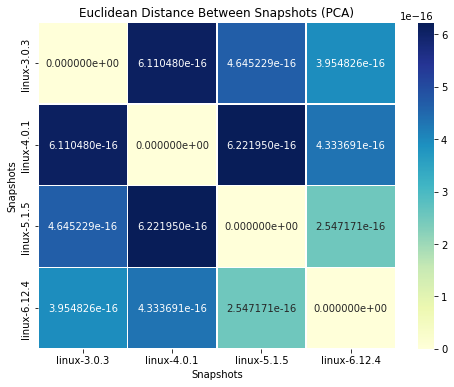

In [514]:
# Plot the PCA Euclidean Distance Matrix
plot_heatmap(pca_euclidean_distances, "Euclidean Distance Between Snapshots (PCA)", "YlGnBu", fmt='.6e')

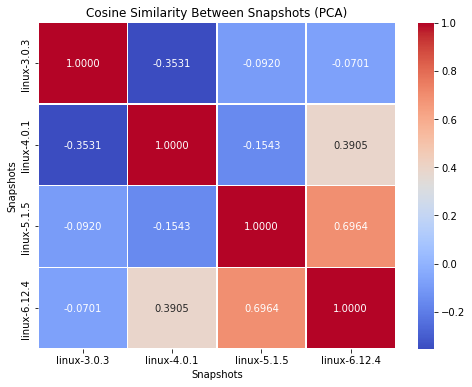

In [515]:
# Plot the PCA Cosine Similarity Matrix
plot_heatmap(pca_cosine_similarities, "Cosine Similarity Between Snapshots (PCA)", "coolwarm")

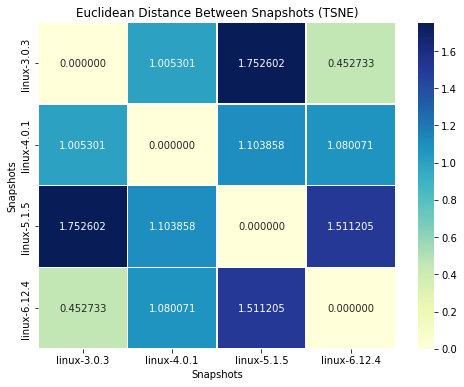

In [516]:
# Plot the t-SNE Euclidean Distance Matrix
plot_heatmap(tsne_euclidean_distances, "Euclidean Distance Between Snapshots (TSNE)", "YlGnBu", fmt='.6f')

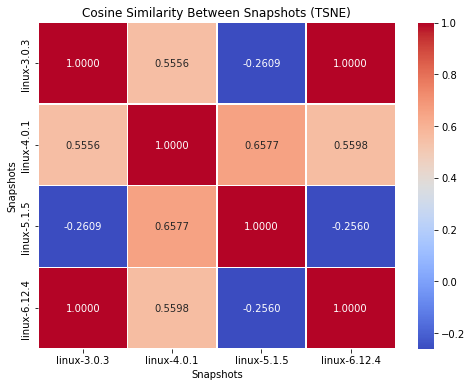

In [517]:
# Plot the t-SNE Cosine Similarity Matrix
plot_heatmap(tsne_cosine_similarities, "Cosine Similarity Between Snapshots (TSNE)", "coolwarm")

## Final Findings: Comparing Snapshots Using PCA and t-SNE

We applied **dimensionality reduction** techniques, **PCA** and **t-SNE**, to generate vector embeddings for the snapshots and compared their relationships using **Euclidean distance** and **Cosine similarity**.

### Cosine Similarity Results:
1. **PCA**:
   - **linux-5.1.5** and **linux-6.12.4** show the strongest similarity (**0.6964**), indicating aligned trends in PCA space.
   - **linux-3.0.3** shows **negative similarity** with other snapshots (e.g., **-0.3531** with linux-4.0.1), suggesting it is directionally opposed to the others.

2. **t-SNE**:
   - **linux-3.0.3** and **linux-6.12.4** have the highest similarity (**1.0000**), indicating close alignment in local structure.
   - **linux-5.1.5** has notable dissimilarities with linux-3.0.3 (**-0.2609**) and linux-6.12.4 (**-0.2560**), suggesting t-SNE uncovered local patterns that differ from PCA results.

### Euclidean Distance Results:
1. **PCA**:
   - The distances are extremely small (on the order of **1e-16**), indicating the mean vectors are nearly identical in PCA space.
   - This suggests PCA compressed the data such that snapshots are very close in magnitude but differ directionally (as shown by cosine similarity).

2. **t-SNE**:
   - The distances reveal meaningful variability between snapshots:
     - **linux-3.0.3** and **linux-6.12.4** are closest (distance = **0.4527**), indicating strong similarity.
     - **linux-3.0.3** and **linux-5.1.5** are farthest apart (distance = **1.7526**), highlighting significant dissimilarity.

### Key Insights:
1. **PCA vs t-SNE**:
   - PCA provides a global view of variance but compresses distances, resulting in minimal Euclidean differences.
   - t-SNE better preserves local structure, revealing clearer patterns of similarity and dissimilarity.

2. **Snapshot Relationships**:
   - **linux-5.1.5** and **linux-6.12.4** show consistent alignment across both PCA and t-SNE.
   - **linux-3.0.3** remains distinct, particularly in PCA where it exhibits negative cosine similarity with other snapshots.

3. **Choosing the Right Method**:
   - Use **PCA** for understanding global variance and trends.
   - Use **t-SNE** for uncovering local relationships and nuanced differences.

### Next Steps:
- Further investigate why **linux-3.0.3** behaves as an outlier across both metrics.
- Explore other techniques like **UMAP** for a balance between global and local structure preservation.
- Use these findings to inform decisions regarding snapshot differences and temporal changes.